# Machine Learning for NCSM 

## Python/Jupyter/Numpy ...


In [136]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import pathlib
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy
import os 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import models
from keras import layers
import tensorflow.keras as keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

tf.keras.backend.set_floatx('float32')

In [137]:
# convert integer to array 
def integer_to_bin_array(N,dim_b=8):
    """ Convert integers into dim_b bits  binary
    """
    import numpy as np
    bin_str = bin(N)[2:] # to binary string 
    if len(bin_str) > dim_b :
        raise ValueError('{} is too large to be {} bits'.format(N,dim_b))
    bin_str=bin_str.zfill(dim_b) #padding zero 
    bin_array=[float(j) for j in bin_str] 
    return bin_array

# NCSM 6Li case

PHYSICAL REVIEW C 99, 054308 (2019)

In [138]:
# Read data 
out = np.loadtxt('6Li.txt')
homega_list = out[1:,0]
nmax_list = out[0,2:]
data = out[1:,2:] # data[i,j] is for (homega[i] ,nmax[j]) 

#====collect data in table form 
data_form =[] 
n=0
for i in range(len(homega_list)):
    for j in range(len(nmax_list)):
        data_form.append([homega_list[i],nmax_list[j],data[i,j]])
        
orig_df = pd.DataFrame.from_records(data_form,columns=['Omega', 'Nmax', 'gs' ])
orig_df.describe()

,Omega,Nmax,gs
count,171.000000,171.000000,171.000000
mean,27.736842,10.000000,-25.990191
std,13.372306,5.179144,9.129361
min,8.000000,2.000000,-31.977100
25%,15.000000,6.000000,-31.314700
50%,27.500000,10.000000,-29.469000
75%,40.000000,14.000000,-24.918950
max,50.000000,18.000000,24.685000


In [139]:
#scaling data 
data_df ={} 
scale_omega = 25.0
data_df['Omega'] = orig_df['Omega']/scale_omega
scale_nmax = 9.0
data_df['Nmax'] = orig_df['Nmax']/scale_nmax
scale_gs = 20.0 
data_df['gs'] = orig_df['gs']/scale_gs

#data_df['1/Nmax'] = 1.0/data_df['Nmax']
#----data frame 
data_df = pd.DataFrame(data_df)

# exclude positive energy data 
data_df = data_df[ data_df['gs']<0.0]

#--split training and test
training_df = data_df[(data_df['Nmax']<18/scale_nmax)]
test_df = data_df[(data_df['Nmax']==18/scale_nmax)]

# random shuffle
training_df = training_df.sample(frac = 1) 
# test_df = test_df.sample(frac = 1)  # no need of shuffle for test data

# separate features and labels 
train_X = training_df.iloc[:,:-1]
train_Y = training_df.iloc[:,-1]

test_X = test_df.iloc[:,:-1]
test_Y = test_df.iloc[:,-1]

data_df.describe()

,Omega,Nmax,gs
count,166.000000,166.000000,166.000000
mean,1.086265,1.136546,-1.357022
std,0.525199,0.564527,0.309464
min,0.320000,0.222222,-1.598855
25%,0.600000,0.666667,-1.568122
50%,1.100000,1.111111,-1.476948
75%,1.500000,1.555556,-1.284260
max,2.000000,2.000000,-0.026785


In [144]:
# NN Model randomness can be removed by initialization with seed. 
#------remove randomness in the NN modeling
def NN_create_fit(np_seed=None,tf_seed=None,summary_q=True,plot_q=True):
    if np_seed : np.random.seed(np_seed)
    if tf_seed : tf.random.set_seed(tf_seed)
    
    #--NN model 
    network = models.Sequential()
    network.add(layers.Dense(6, activation='tanh', input_shape=(2,), 
                             kernel_initializer=tf.keras.initializers.RandomNormal(
                                    mean=1.0, stddev=0.1),
                             bias_initializer='zeros', )
               )
    network.add(layers.Dense(2, activation='tanh',  
                             kernel_initializer=tf.keras.initializers.RandomNormal(
                               mean=1.0, stddev=0.1),
                             bias_initializer='zeros',)
               )
    network.add(layers.Dense(1,activation='linear',
                            kernel_initializer=tf.keras.initializers.RandomNormal(
                               mean=1.0, stddev=0.1),
                            bias_initializer='zeros',)
               )    
    network.compile(optimizer="Adam",loss='MSE') # Adam ? SGD ? 
    # Early stopping 
    es = EarlyStopping(monitor='loss', min_delta=0.0002, patience=200,restore_best_weights=True)
    # model checkpoint 
    #mc= None
    # mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
    #==== fit ====
    history = network.fit(train_X, train_Y, epochs=5000,verbose=False,batch_size=50,callbacks=[])
    mse = network.evaluate(train_X,train_Y)*scale_gs
    if summary_q: network.summary()
    if plot_q :
        plt.plot(np.arange(len(history.history['loss'][10:]  )), history.history['loss'][10:])
        print('MSE(train)= {}'.format(network.evaluate(train_X,train_Y)*scale_gs ))
        print('MSE(test)= {}'.format(network.evaluate(test_X,test_Y)*scale_gs ))    
    return network ,mse 

def NN_plot(network,large_nmax=70,hw=30):
    # nmax extrapolation 
    ext_X= np.array([ [i, large_nmax/scale_nmax] for i in np.linspace(0.25,2.0)  ])
    ext_Y = network.predict(ext_X)
    print('Nmax={} E= {}+/-{}'.format(large_nmax, ext_Y.mean()*scale_gs, ext_Y.std()*scale_gs))
    print('         error bar is from the omega dependence')
    #--plot hw dependence with nmax 
    plt.figure()
    plt.plot(train_X['Omega']*scale_omega,network.predict(train_X)*scale_gs ,'g*',label='NN train') 
    plt.plot(train_X['Omega']*scale_omega,train_Y*scale_gs,'b.')
    plt.plot(test_X['Omega']*scale_omega,network.predict(test_X)*scale_gs ,'r*',label='NN test') 
    plt.plot(test_X['Omega']*scale_omega,test_Y*scale_gs,'.')
    # extrapolation
    plt.plot(ext_X[:,0]*scale_omega,ext_Y*scale_gs,'p-',label='NN nmax={}'.format(large_nmax)) 
    plt.xlabel('h*omega') 
    plt.ylabel('MeV')
    plt.legend()   
    #---nmax dependence of fit plot 
    plt.figure()
    ext_X = np.array([ [hw/scale_omega, i] for i in np.linspace(0.1,5,100) ])
    ext_Y = network.predict(ext_X)
    plt.figure()
    plt.plot(ext_X[:,1]*scale_nmax,ext_Y*scale_gs)
    plt.title('fixed hw={} results'.format(hw))
    plt.xlabel('Nmax [a.u.]')
    return 

5/5 [==============================] - 0s 2ms/step - loss: 1.7750e-04
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_176 (Dense)            (None, 6)                 18        
_________________________________________________________________
dense_177 (Dense)            (None, 2)                 14        
_________________________________________________________________
dense_178 (Dense)            (None, 1)                 3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________
5/5 [==============================] - 0s 4ms/step - loss: 1.7750e-04
MSE(train)= 0.003549969696905464
1/1 [==============================] - 0s 2ms/step - loss: 1.4612e-04
MSE(test)= 0.0029223470482975245
Nmax=70 E= -32.194151878356934+/-0.06019827909767628
         error bar is from the omega dependence


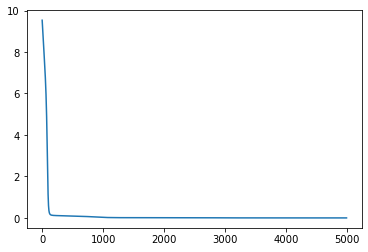

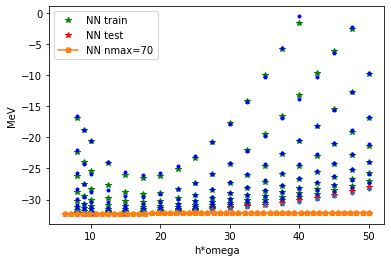

<Figure size 432x288 with 0 Axes>

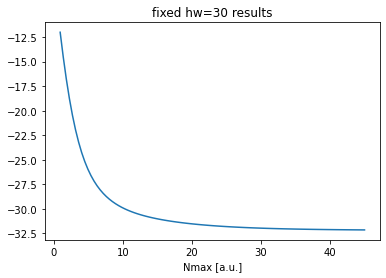

In [145]:
network, mse = NN_create_fit()  
NN_plot(network)

In [ ]:
selected_models=[]
for i in range(100):
    network, mse = NN_create_fit()  
    

## Restricted extrapolation NN

The general feature we expect from the extrapolation is that 

* At large $N_{max}$, the $E_{gs}$ to be independent of $\hbar\Omega$.
* At lerge $N_{max}$ with fixed $\hbar\Omega$ to converge one value. 
  $$ E_{gs}(N_{max}) \sim a \exp(- b N_{max}) + c $$
  
In general, ANN has no resctiction on the function space. Thus, extrapolation can have un-desirable feature at large $N_{max}$.
To prevent/exclude such extrapolarion we may 
* Select some ANN which satisfies some class of resctions.
* Impose asymptotic boundary condition explicitly on the ANN output. 

We may impose 
  $$ E_{gs}(N_{max},\hbar\Omega) = f(N_{max},\hbar\Omega) \exp(- g(N_{max},\hbar\Omega) N_{max}) + E_0 $$
and use ANN to represent $f$ and $g$.   
  

In [110]:
class Li6Extrapolation(tf.keras.models.Model):
    """Create a neural network eave function in N dimensions

    Boundary condition, if not supplied, is gaussian in every dimension

    Extends:
        tf.keras.models.Model
    """
    def __init__(self, initial_E0 : float = 0.0):
        tf.keras.models.Model.__init__(self)        
        self.layer1 = tf.keras.layers.Dense(8, use_bias=True)
        self.layer2 = tf.keras.layers.Dense(2, use_bias=True)
        #self.layer3 = tf.keras.layers.Dense(1, use_bias=True)
        self._E0 = tf.Variable(initial_E0, trainable = True)        
        #self._a = tf.Variable(1.0,trainable=True)
        #self._b = tf.Variable(1.0,trainable=True)
#    @tf.function
    def call(self, inputs):
        # input shape is [ [hbar Omega , Nmax] ]        
        x = self.layer1(inputs)
        x = tf.keras.activations.tanh(x)
        x = self.layer2(x)
        #y2 = self.layer3(x)
        #y1 = tf.keras.activations.sigmoid(y1)
        #y2 = tf.keras.activations.sigmoid(y2)
        #x = tf.keras.activations.tanh(x)
        #x = y1*tf.exp(-tf.abs(y2)*inputs[:,1])+self._E0
        x = x[:,0]*tf.exp(-tf.abs(x[:,1])*inputs[:,1])+self._E0
        #x = y1*tf.exp(-tf.abs(y2)*inputs[1])+self._E0
        #x = self._a*tf.exp(-self._b*inputs[:,1])+self._E0
        return x 


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Model: "li6_extrapolation_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_140 (Dense)            multiple                  24        
_________________________________________________________________
dense_141 (Dense)            multiple                  18        
Total params: 43
Trainable params: 43
Non-trainable params: 0
_________________________________________________________________
5/5 [===============

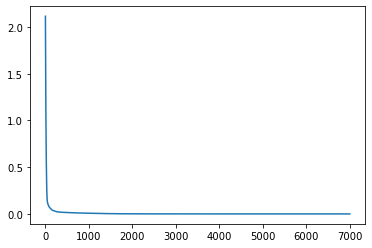

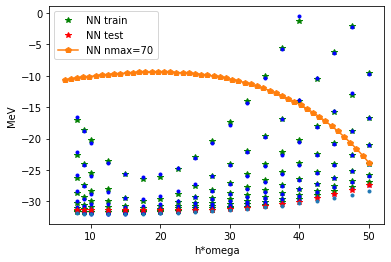

<Figure size 432x288 with 0 Axes>

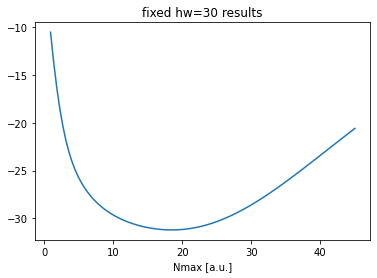

In [115]:
restriced_model = Li6Extrapolation()
restriced_model.compile(optimizer="Adam",loss='MSE')
history = restriced_model.fit(train_X, train_Y, epochs=7000,verbose=False,batch_size=None)
restriced_model.summary()
plt.plot(np.arange( len(history.history['loss'])), history.history['loss'])
print('MSE(train)= {}'.format(restriced_model.evaluate(train_X,train_Y)*scale_gs ))
print('MSE(test)= {}'.format(restriced_model.evaluate(test_X,test_Y)*scale_gs ))  
NN_plot(restriced_model)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Nmax=90.0 E= -31.86116933822632+/-2.384185791015625e-06

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocas

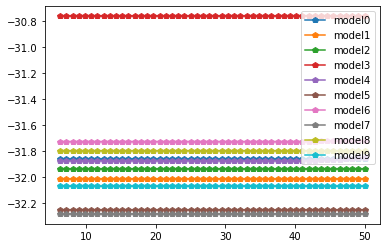

In [98]:
large_nmax = 90.0
ext_X= np.array([ [i, large_nmax/scale_nmax] for i in np.linspace(0.25,2.0)  ]) #large Nmax 

for i in range(10):
    model = Li6Extrapolation()
    model.compile(optimizer="Adam",loss='MSE')
    history = model.fit(train_X, train_Y, epochs=5000,verbose=False,batch_size=50)    
    ext_Y = model.predict(ext_X) 
    print('Nmax={} E= {}+/-{}'.format(large_nmax, ext_Y.mean()*scale_gs, ext_Y.std()*scale_gs))
    plt.plot(ext_X[:,0]*scale_omega,ext_Y*scale_gs,'p-',label='model{}'.format(i)) 
plt.legend()   

# Gaussian process

In [10]:
# tool to plot Gaussian process 
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu,'*', label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()
    
from numpy.linalg import cholesky, det, lstsq
from scipy.optimize import minimize


In [11]:
noise=0.05/scale_gs
rbf = ConstantKernel(1.4) * RBF(length_scale=0.5)
gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise**2) 

# Reuse training data from previous 1D example
gpr.fit(train_X, train_Y)

# Compute posterior predictive mean and covariance
mu_s, cov_s = gpr.predict(test_X, return_cov=True)

# Obtain optimized kernel parameters
l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])

print('Optimized Kernel parameters?')
print(l)
print(sigma_f)
# Compare with previous results
#assert(np.isclose(l_opt, l))
#assert(np.isclose(sigma_f_opt, sigma_f))

Optimized Kernel parameters?
0.5045585312037412
3.4785354034880123


Text(0.5, 0, 'hw [a.u.]')

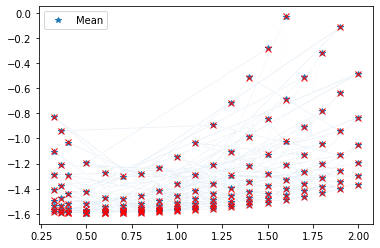

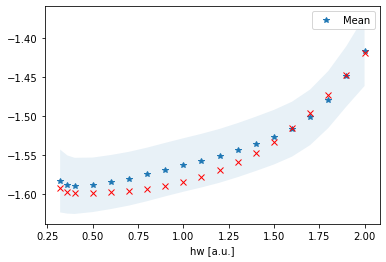

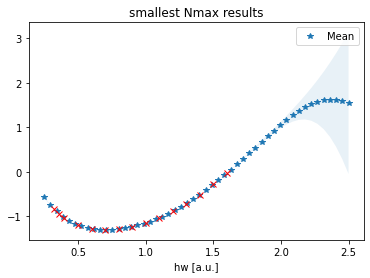

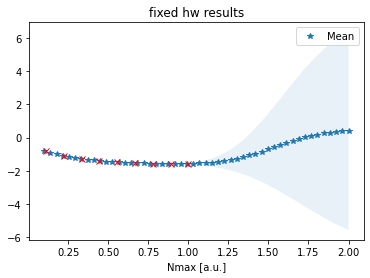

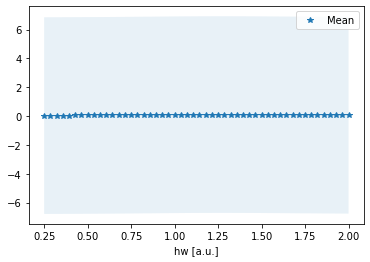

In [12]:
# training result
mu_s, cov_s = gpr.predict(train_X, return_cov=True)
plt.figure()
plot_gp(mu_s, cov_s, train_X['Omega'], X_train=train_X['Omega'], Y_train=train_Y)

# test result
mu_s, cov_s = gpr.predict(test_X, return_cov=True)
plt.figure()
plot_gp(mu_s, cov_s, test_X['Omega'], X_train=test_X['Omega'], Y_train=test_Y)
plt.xlabel('hw [a.u.]')

# for one Nmax, hw dependence  
ttt = data_df[ data_df['Nmax']==data_df['Nmax'][0]  ] # already scaled 
ttt_X = ttt.iloc[:,:-1]
ttt_Y = ttt.iloc[:,-1]

ext_X= np.array([ [i, ttt_X['Nmax'][0]] for i in np.linspace(0.25,2.5)  ])
mu_s, cov_s = gpr.predict(ext_X, return_cov=True)
plt.figure()
plot_gp(mu_s, cov_s, ext_X[:,0], X_train=ttt_X['Omega'], Y_train=ttt_Y)
plt.title('smallest Nmax results')
plt.xlabel('hw [a.u.]')

# for one hw, Nmax dependence  
ttt = data_df[ data_df['Omega']==data_df['Omega'][6]  ] # already scaled 
ttt_X = ttt.iloc[:,:-1]
ttt_Y = ttt.iloc[:,-1]

ext_X= np.array([ [ttt_X['Omega'][0], i] for i in np.linspace(0.1,2) ])
mu_s, cov_s = gpr.predict(ext_X, return_cov=True)
plt.figure()
plot_gp(mu_s, cov_s, ext_X[:,1], X_train=ttt_X['Nmax'], Y_train=ttt_Y)
plt.title('fixed hw results')
plt.xlabel('Nmax [a.u.]')

# extrapolation result
ext_X= np.array([ [i, 50./scale_nmax] for i in np.linspace(0.25,2.0)  ])
mu_s, cov_s = gpr.predict(ext_X, return_cov=True)
plt.figure()
plot_gp(mu_s, cov_s, ext_X[:,0])   
plt.xlabel('hw [a.u.]')

# NCSM 11Be

## Be11 positive parity

In [13]:
#-----read data for positive parity 
Be11p = np.loadtxt('11Be_p.txt')

Be11p_omega = Be11p[1:,0]
Be11p_nmax = Be11p[0,1:]
Be11p_data = Be11p[1:,1:]

#====collect data in table form 
Be11p_df = [] 
for i in range(len(Be11p_omega)):
    for j in range(len(Be11p_nmax)):
        Be11p_df.append([Be11p_omega[i],Be11p_nmax[j],Be11p_data[i,j]])
Be11p_df = pd.DataFrame.from_records(Be11p_df,columns=['Omega', 'Nmax', 'gs' ])

#--discard positive b.e.
Be11p_df = Be11p_df[Be11p_df['gs']<0.0]

Be11p_df.describe()

,Omega,Nmax,gs
count,77.000000,77.000000,77.000000
mean,21.655844,5.909091,-44.480371
std,10.184243,3.052962,16.278576
min,8.000000,1.000000,-64.399600
25%,12.500000,3.000000,-58.469300
50%,20.000000,7.000000,-48.388400
75%,30.000000,9.000000,-34.339500
max,45.000000,11.000000,-5.143900


In [14]:
#---scale and split data
#scaling data 
Be11p_scale_omega = 20.0
Be11p_df['Omega'] = Be11p_df['Omega']/Be11p_scale_omega
Be11p_scale_nmax = 7.0
Be11p_df['Nmax'] = Be11p_df['Nmax']/Be11p_scale_nmax
Be11p_scale_gs = 40.0 
Be11p_df['gs'] = Be11p_df['gs']/Be11p_scale_gs

#--split training and test
Be11p_train_df = Be11p_df[(Be11p_df['Nmax']<11/Be11p_scale_nmax)]
Be11p_test_df = Be11p_df[(Be11p_df['Nmax']==11/Be11p_scale_nmax)]

# random shuffle
Be11p_train_df = Be11p_train_df.sample(frac = 1) 
# Be11p_test_df = Be11p_test_df.sample(frac = 1)  

# separate features and labels 
Be11p_train_X = Be11p_train_df.iloc[:,:-1]
Be11p_train_Y = Be11p_train_df.iloc[:,-1]

Be11p_test_X = Be11p_test_df.iloc[:,:-1]
Be11p_test_Y = Be11p_test_df.iloc[:,-1]

Be11p_df.describe()

,Omega,Nmax,gs
count,77.000000,77.000000,77.000000
mean,1.082792,0.844156,-1.112009
std,0.509212,0.436137,0.406964
min,0.400000,0.142857,-1.609990
25%,0.625000,0.428571,-1.461732
50%,1.000000,1.000000,-1.209710
75%,1.500000,1.285714,-0.858488
max,2.250000,1.571429,-0.128598


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 6)                 18        
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 14        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________
3/3 [==============================] - 0s 997us/step - loss: 8.5422e-04
MSE(train)= 0.034168974962085485
1/1 [==============================] - 0s 1ms/step - loss: 8.9660e-04
MSE(test)= 0.03586403792724013


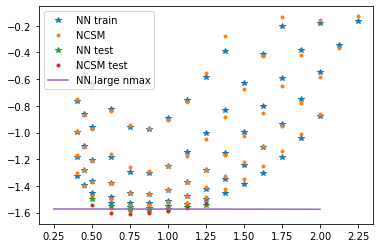

In [19]:
Be11p_NN = models.Sequential()
Be11p_NN.add(layers.Dense(6, activation='tanh', input_shape=(2,)))
Be11p_NN.add(layers.Dense(2, activation='tanh',))
Be11p_NN.add(layers.Dense(1, activation=None))

Be11p_NN.compile(optimizer='Adam',
               loss='MSE')
Be11p_NN.summary()

Be11p_NN.fit(Be11p_train_X, Be11p_train_Y, epochs=4000, batch_size=50, verbose=False)
print('MSE(train)= {}'.format(Be11p_NN.evaluate(Be11p_train_X,Be11p_train_Y)*Be11p_scale_gs ))
print('MSE(test)= {}'.format( Be11p_NN.evaluate(Be11p_test_X,Be11p_test_Y)*Be11p_scale_gs ))

# For example 
plt.figure()
plt.plot(Be11p_train_X['Omega'],Be11p_NN.predict(Be11p_train_X) ,'*',label='NN train') 
plt.plot(Be11p_train_X['Omega'],Be11p_train_Y,'.',label='NCSM')
plt.plot(Be11p_test_X['Omega'],Be11p_NN.predict(Be11p_test_X) ,'*',label='NN test') 
plt.plot(Be11p_test_X['Omega'],Be11p_test_Y,'.',label='NCSM test')
# extrapolation
ext_X=np.array([ [i, 20.] for i in np.linspace(0.25,2.0)  ])
plt.plot(ext_X[:,0],Be11p_NN.predict(ext_X),label='NN large nmax') 
plt.legend()

## Be11 negative parity

In [16]:
#-----read data for negative parity
Be11m = np.loadtxt('11Be_m.txt')

Be11m_omega = Be11m[1:,0]
Be11m_nmax = Be11m[0,2:]
Be11m_data = Be11p[1:,2:]

#====collect data in table form 
Be11m_df = [] 
for i in range(len(Be11m_omega)):
    for j in range(len(Be11m_nmax)):
        Be11m_df.append([Be11m_omega[i],Be11m_nmax[j],Be11m_data[i,j]])
Be11m_df = pd.DataFrame.from_records(Be11m_df,columns=['Omega', 'Nmax', 'gs' ])

#--discard positive b.e.
Be11m_df = Be11m_df[Be11m_df['gs']<0.0]

Be11m_df.describe()

,Omega,Nmax,gs
count,67.000000,67.000000,67.000000
mean,22.395522,5.641791,-46.968685
std,10.422345,2.556640,15.665715
min,8.000000,2.000000,-64.399600
25%,12.500000,4.000000,-59.198450
50%,22.500000,6.000000,-51.189100
75%,30.000000,8.000000,-39.147300
max,45.000000,10.000000,-5.143900


In [17]:
#---scale and split data
#scaling data 
Be11m_scale_omega = 20.0
Be11m_df['Omega'] = Be11m_df['Omega']/Be11m_scale_omega
Be11m_scale_nmax = 7.0
Be11m_df['Nmax'] = Be11m_df['Nmax']/Be11m_scale_nmax
Be11m_scale_gs = 40.0 
Be11m_df['gs'] = Be11m_df['gs']/Be11m_scale_gs

#--split training and test
Be11m_train_df = Be11m_df[(Be11m_df['Nmax']<10/Be11m_scale_nmax)]
Be11m_test_df = Be11m_df[(Be11m_df['Nmax']==10/Be11m_scale_nmax)]

# random shuffle
Be11m_train_df = Be11m_train_df.sample(frac = 1) 
# Be11m_test_df = Be11m_test_df.sample(frac = 1)  

# separate features and labels 
Be11m_train_X = Be11m_train_df.iloc[:,:-1]
Be11m_train_Y = Be11m_train_df.iloc[:,-1]

Be11m_test_X = Be11m_test_df.iloc[:,:-1]
Be11m_test_Y = Be11m_test_df.iloc[:,-1]

Be11m_df.describe()

,Omega,Nmax,gs
count,67.000000,67.000000,67.000000
mean,1.119776,0.805970,-1.174217
std,0.521117,0.365234,0.391643
min,0.400000,0.285714,-1.609990
25%,0.625000,0.571429,-1.479961
50%,1.125000,0.857143,-1.279728
75%,1.500000,1.142857,-0.978683
max,2.250000,1.428571,-0.128598


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 6)                 18        
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 14        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 997us/step - loss: 0.0012
0.00124117243103683
1/1 [==============================] - 0s 999us/step - loss: 0.0039
0.0039162663742899895
========Train data==========
=======large Nmax============


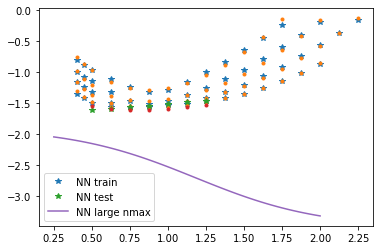

In [20]:
Be11m_NN = models.Sequential()
Be11m_NN.add(layers.Dense(6, activation='tanh', input_shape=(2,)))
Be11m_NN.add(layers.Dense(2, activation='relu'))
Be11m_NN.add(layers.Dense(1, activation=None))

Be11m_NN.compile(optimizer='Adam',
               loss='MSE')

Be11m_NN.summary()

Be11m_NN.fit(Be11m_train_X, Be11m_train_Y, epochs=3000, batch_size=50, verbose=False)
print( Be11m_NN.evaluate(Be11m_train_X,Be11m_train_Y) )
print( Be11m_NN.evaluate(Be11m_test_X,Be11m_test_Y) )

print('========Train data==========')
plt.figure()
plt.plot(Be11m_train_X['Omega'],Be11m_NN.predict(Be11m_train_X) ,'*',label='NN train') 
plt.plot(Be11m_train_X['Omega'],Be11m_train_Y,'.')
plt.plot(Be11m_test_X['Omega'],Be11m_NN.predict(Be11m_test_X) ,'*',label='NN test') 
plt.plot(Be11m_test_X['Omega'],Be11m_test_Y,'.')
# extrapolation
print('=======large Nmax============')
ext_X=np.array([ [i, 30.] for i in np.linspace(0.25,2.0)  ])
plt.plot(ext_X[:,0],Be11m_NN.predict(ext_X),label='NN large nmax') 
plt.legend()